In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
# import roc curve 
from sklearn.metrics import roc_curve, auc

In [148]:
def preprocess_data(data, use_smote):
    """
    Preprocess the data for multi-class classification.
    """
    # Encode string labels as integers
    le = LabelEncoder()
    y = le.fit_transform(data['Label'])

    # Store encoder for reverse lookup later (optional)
    data['Label_encoded'] = y

    # Define features (exclude 'time', 'url', 'Label', and 'Label_encoded')
    X = data.drop(columns=['time', 'url', 'Label', 'Label_encoded'])
    y = data['Label_encoded']

    # Store feature names for later use
    feature_names = X.columns.tolist()

    # Train/test split with stratification based on 'Label_encoded'
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Choose resampling method based on the flag
    if use_smote:
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    else:
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Return the processed data
    return X_resampled, X_test, y_resampled, y_test, feature_names, le

def lasso_feature_selection(X, y, cv=5):
    """Apply logistic regression (with L1 regularization) for feature selection."""
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Encode target labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    print("Fitting LogisticRegressionCV with L1 penalty for feature selection...")
    clf = LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        multi_class='multinomial',
        cv=cv,
        random_state=42,
        max_iter=10000
    )
    clf.fit(X_scaled, y_encoded)

    selector = SelectFromModel(clf, prefit=True, threshold="mean")
    X_selected = selector.transform(X_scaled)
    selected_features = X.columns[selector.get_support()]

    print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
    for feature in selected_features:
        print(f"- {feature}")

    X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
    return X_selected_df, selected_features, scaler, selector

def train_xgboost(X_train, y_train):
    """Train XGBoost classifier with hyperparameter tuning"""
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    # Create XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    )
    
    # Set up Grid Search with stratified k-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    
    # Fit Grid Search
    print("Tuning hyperparameters with GridSearchCV...")
    grid_search.fit(X_train, y_train)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    
    # Train model with best parameters
    best_model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        **best_params
    )
    
    # Train final model
    best_model.fit(X_train, y_train)
    
    return best_model


def train_multi_class_model(X_train, y_train):
    """
    Train a multi-class classification model using Random Forest.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels

    Returns:
    - model: Trained Random Forest model
    - cross_val_scores: Cross-validation scores
    """
    # Initialize the Random Forest classifier
    model = RandomForestClassifier(n_estimators=700, max_depth=20, random_state=42)
    
    # Train the model on the full training set
    model.fit(X_train, y_train)

    # do cross validation on the training set 
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cross_val_scores}")
    print(f"Mean cross-validation accuracy: {cross_val_scores.mean():.4f}")

    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test set.
    
    Parameters:
    - model: Trained Random Forest model
    - X_test: Test features
    - y_test: Test labels

    Returns:
    - report: Classification report
    - accuracy: Accuracy score
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # generate values for ROC curve and after predicting on y_pred
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=np.unique(y_test), output_dict=True)
  

    return report, accuracy

def plot_feature_importance(model, feature_names):
    """
    Plot feature importance for the trained Random Forest model.
    
    Parameters:
    - model: Trained Random Forest model
    - feature_names: List of feature names
    """
    # Extract feature importance
    importance = model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def extract_features_from_averaged_eeg(data):
    """
    Extract features from already averaged EEG data
    
    Parameters:
    -----------
    data : DataFrame with columns ['time spent on this reel', 'EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.AF4', 'Label']
    
    Returns:
    --------
    features_df : DataFrame with original and derived features
    """
    # Create a copy to avoid modifying the original
    features_df = data.copy()
    
    # 1. Channel ratios (relationship between different brain regions)
    features_df['frontal_ratio'] = features_df['EEG.AF3'] / features_df['EEG.AF4'].replace(0, np.nan)
    features_df['frontal_ratio'] = features_df['frontal_ratio'].fillna(1)  # Handle division by zero
    
    features_df['temporal_parietal_ratio'] = features_df['EEG.T7'] / features_df['EEG.Pz'].replace(0, np.nan)
    features_df['temporal_parietal_ratio'] = features_df['temporal_parietal_ratio'].fillna(1)
    
    # 2. Frontal Asymmetry (important for emotional processing)
    features_df['frontal_asymmetry'] = features_df['EEG.AF4'] - features_df['EEG.AF3']
    
    # 3. Average activity across regions
    features_df['frontal_avg'] = (features_df['EEG.AF3'] + features_df['EEG.AF4']) / 2
    features_df['overall_avg'] = features_df[['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.AF4']].mean(axis=1)
    
    # 4. Variance across channels (measure of overall brain synchrony)
    features_df['channel_variance'] = features_df[['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.AF4']].var(axis=1)
    
    # 5. Engagement measures
    # Frontal and parietal activity often associated with attention/engagement
    features_df['engagement_index'] = (features_df['EEG.AF3'] + features_df['EEG.AF4'] + features_df['EEG.Pz']) / 3
    
    # 6. Create features using squared and cubic terms (non-linear relationships)
    for channel in ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.AF4']:
        features_df[f'{channel}_squared'] = features_df[channel] ** 2
    
    # 7. Interaction terms between channels
    features_df['AF3_T7_interaction'] = features_df['EEG.AF3'] * features_df['EEG.T7']
    features_df['AF4_Pz_interaction'] = features_df['EEG.AF4'] * features_df['EEG.Pz']
    
    # 8. Normalized engagement vs. time
    features_df['engagement_per_second'] = features_df['engagement_index'] / features_df['time spent on this reel']
    
    # 9. Log transformations (to handle skewed distributions)
    for channel in ['EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.AF4']:
        # Add small constant to avoid log(0)
        features_df[f'{channel}_log'] = np.log(np.abs(features_df[channel]) + 1e-10)
    
    # 10. Simulated band power ratios based on channel locations
    # AF3 and AF4 have more beta and gamma activity (frontal executive)
    # T7 has more alpha (auditory processing)
    # Pz has more alpha and theta (sensory integration)
    features_df['simulated_theta_beta'] = (features_df['EEG.Pz'] + features_df['EEG.T7']) / (features_df['EEG.AF3'] + features_df['EEG.AF4'] + 1e-10)
    features_df['simulated_alpha_ratio'] = (features_df['EEG.T7'] + features_df['EEG.Pz']) / (features_df['overall_avg'] + 1e-10)
    
    # 11. Time-normalized features
    features_df['AF3_per_second'] = features_df['EEG.AF3'] / features_df['time spent on this reel']
    features_df['AF4_per_second'] = features_df['EEG.AF4'] / features_df['time spent on this reel']
    features_df['T7_per_second'] = features_df['EEG.T7'] / features_df['time spent on this reel']
    features_df['Pz_per_second'] = features_df['EEG.Pz'] / features_df['time spent on this reel']
    
    # 12. Custom features inspired by your plots
    # Simulating a feature that captures the delta/beta ratio pattern
    features_df['custom_activation_index'] = (features_df['EEG.AF3'] * features_df['EEG.Pz']) / (features_df['EEG.T7'] + 1e-10)
    
    return features_df

In [149]:
data = pd.read_csv('reel_eeg_data.csv')
del data["label"]
new_label = ["Neutral" if label == "Interested" else label for label in data["Label"]]
new_label = ["Excited" if label == "Funny" else label for label in new_label]
new_label = ["Neutral" if label == "Sad" else label for label in new_label]
data["Label"] = new_label
data

,time,url,time spent on this reel,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4,Label
0,17:10:21,https://www.instagram.com/reels/DHl1NfMsE-a/,41.0,4230.400374,4243.084936,4082.138078,4220.904204,Neutral
1,17:11:02,https://www.instagram.com/reels/DHq67Pfvpkm/,9.0,4227.094920,4246.773727,4082.154553,4220.463637,Neutral
2,17:11:11,https://www.instagram.com/reels/DCZgltAh7mI/,6.0,4211.022630,4223.947483,4063.663529,4206.160854,Excited
3,17:11:17,https://www.instagram.com/reels/DG-5yNEJjJX/,25.0,4234.912460,4246.478404,4086.333774,4225.174516,Excited
4,17:11:42,https://www.instagram.com/reels/DFbAj8FyW06/,18.0,4228.611778,4244.216854,4081.364519,4220.788039,Excited
...,...,...,...,...,...,...,...,...
97,17:57:25,https://www.instagram.com/reels/DHrh66Dui-7/,4.0,4211.387717,4210.235124,4065.204580,4206.110530,Neutral
98,17:57:29,https://www.instagram.com/reels/DHt0rz2BFt7/,7.0,4238.923859,4236.365614,4090.300773,4227.251320,Excited
99,17:57:36,https://www.instagram.com/reels/DHmbQG1saBl/,15.0,4235.776982,4233.846416,4086.978430,4223.465876,Excited
100,17:57:51,https://www.instagram.com/reels/DHlVfGjOEGJ/,3.0,4225.301470,4234.955928,4087.084669,4220.840672,Excited


In [150]:
data["Label"].value_counts()

Label
Neutral    73
Excited    29
Name: count, dtype: int64

In [151]:
data = data.dropna()
data = data.reset_index(drop=True)
data = extract_features_from_averaged_eeg(data)
data

,time,url,time spent on this reel,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4,Label,frontal_ratio,temporal_parietal_ratio,...,EEG.T7_log,EEG.Pz_log,EEG.AF4_log,simulated_theta_beta,simulated_alpha_ratio,AF3_per_second,AF4_per_second,T7_per_second,Pz_per_second,custom_activation_index
0,17:10:21,https://www.instagram.com/reels/DHl1NfMsE-a/,41.0,4230.400374,4243.084936,4082.138078,4220.904204,Neutral,1.002250,1.039427,...,8.353046,8.314376,8.347805,0.985081,1.984969,103.180497,102.948883,103.489876,99.564343,4069.934662
1,17:11:02,https://www.instagram.com/reels/DHq67Pfvpkm/,9.0,4227.094920,4246.773727,4082.154553,4220.463637,Neutral,1.001571,1.040327,...,8.353915,8.314380,8.347700,0.985957,1.985858,469.677213,468.940404,471.863747,453.572728,4063.238563
2,17:11:11,https://www.instagram.com/reels/DCZgltAh7mI/,6.0,4211.022630,4223.947483,4063.663529,4206.160854,Excited,1.001156,1.039443,...,8.348525,8.309840,8.344306,0.984606,1.984487,701.837105,701.026809,703.991247,677.277255,4051.229128
3,17:11:17,https://www.instagram.com/reels/DG-5yNEJjJX/,25.0,4234.912460,4246.478404,4086.333774,4225.174516,Excited,1.002305,1.039190,...,8.353845,8.315403,8.348816,0.984956,1.984842,169.396498,169.006981,169.859136,163.453351,4075.204009
4,17:11:42,https://www.instagram.com/reels/DFbAj8FyW06/,18.0,4228.611778,4244.216854,4081.364519,4220.788039,Excited,1.001854,1.039901,...,8.353313,8.314187,8.347777,0.985346,1.985238,234.922877,234.488224,235.789825,226.742473,4066.358216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,17:57:25,https://www.instagram.com/reels/DHrh66Dui-7/,4.0,4211.387717,4210.235124,4065.204580,4206.110530,Neutral,1.001255,1.035676,...,8.345274,8.310219,8.344294,0.983123,1.982980,1052.846929,1051.527633,1052.558781,1016.301145,4066.317469
95,17:57:29,https://www.instagram.com/reels/DHt0rz2BFt7/,7.0,4238.923859,4236.365614,4090.300773,4227.251320,Excited,1.002761,1.035710,...,8.351461,8.316374,8.349307,0.983522,1.983385,605.560551,603.893046,605.195088,584.328682,4092.770813
96,17:57:36,https://www.instagram.com/reels/DHmbQG1saBl/,15.0,4235.776982,4233.846416,4086.978430,4223.465876,Excited,1.002915,1.035936,...,8.350866,8.315561,8.348411,0.983637,1.983502,282.385132,281.564392,282.256428,272.465229,4088.842027
97,17:57:51,https://www.instagram.com/reels/DHlVfGjOEGJ/,3.0,4225.301470,4234.955928,4087.084669,4220.840672,Excited,1.001057,1.036180,...,8.351128,8.315587,8.347790,0.985307,1.985198,1408.433823,1406.946891,1411.651976,1362.361556,4077.767315


In [136]:
data.columns

Index(['time', 'url', 'time spent on this reel', 'EEG.AF3', 'EEG.T7', 'EEG.Pz',
       'EEG.AF4', 'Label', 'frontal_ratio', 'temporal_parietal_ratio',
       'frontal_asymmetry', 'frontal_avg', 'overall_avg', 'channel_variance',
       'engagement_index', 'EEG.AF3_squared', 'EEG.T7_squared',
       'EEG.Pz_squared', 'EEG.AF4_squared', 'AF3_T7_interaction',
       'AF4_Pz_interaction', 'engagement_per_second', 'EEG.AF3_log',
       'EEG.T7_log', 'EEG.Pz_log', 'EEG.AF4_log', 'simulated_theta_beta',
       'simulated_alpha_ratio', 'AF3_per_second', 'AF4_per_second',
       'T7_per_second', 'Pz_per_second', 'custom_activation_index'],
      dtype='object')

Cross-validation scores: [0.5        0.8        0.7        0.78947368 0.84210526]
Mean cross-validation accuracy: 0.7263
Test Accuracy: 0.5667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.68      0.77      0.72        22

    accuracy                           0.57        30
   macro avg       0.34      0.39      0.36        30
weighted avg       0.50      0.57      0.53        30



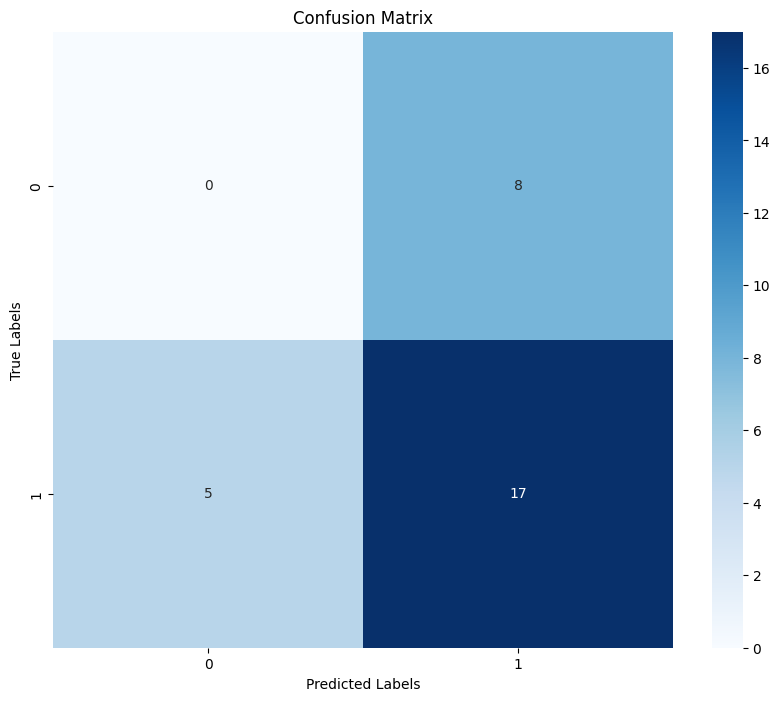

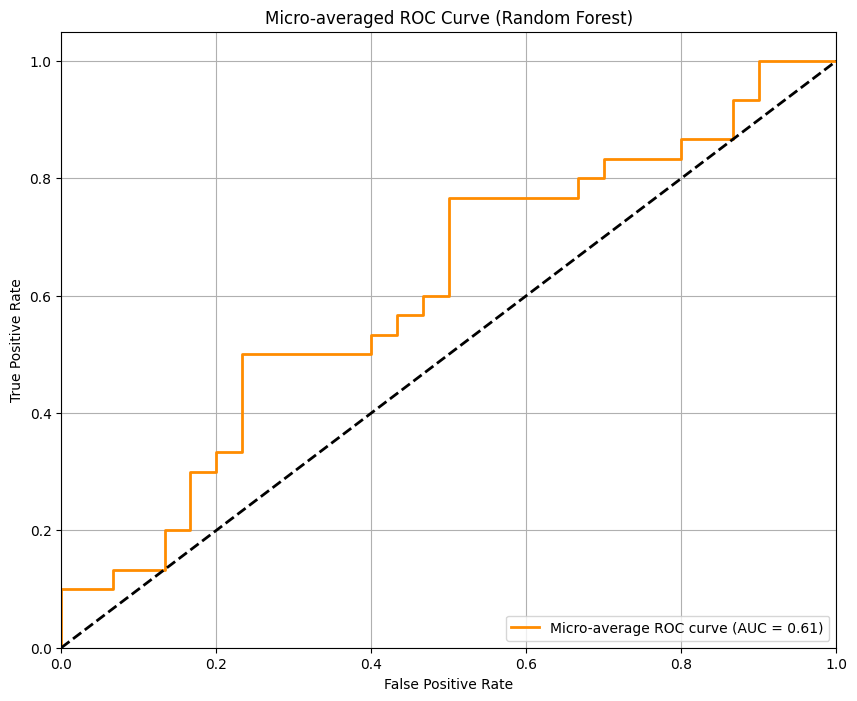


--- Feature Importance ---


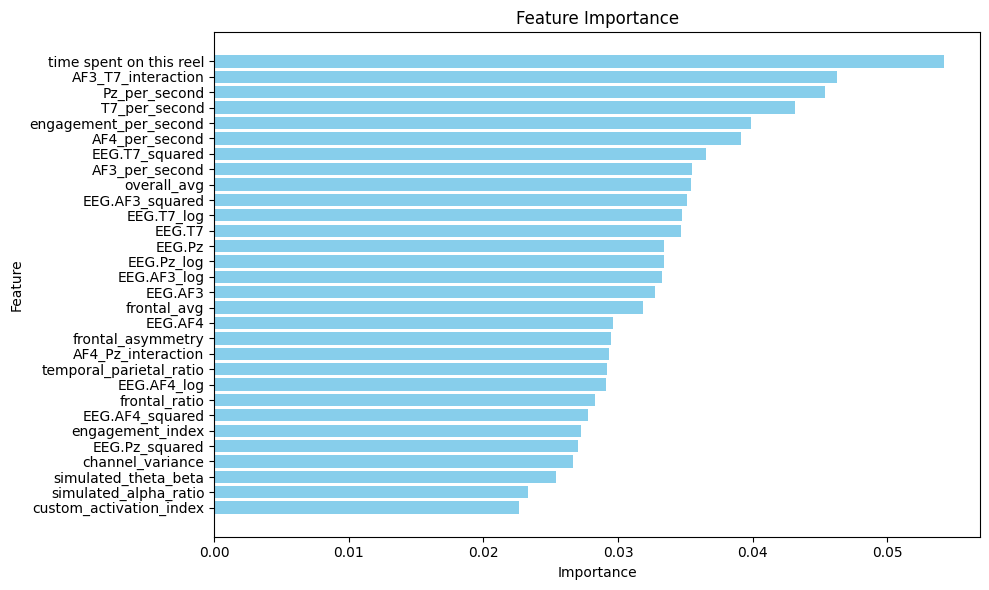

Top 10 important features:


AttributeError: 'NoneType' object has no attribute 'head'

In [161]:
from sklearn.preprocessing import label_binarize

X_train, X_test, y_train, y_test, feature_names, label_encoder = preprocess_data(data, True)
# X_train_selected, selected_features, scaler, lasso_model = lasso_feature_selection(X_train, y_train)
        
# # Transform test set
# X_test_scaled = scaler.transform(X_test)
# X_test_selected = lasso_model.transform(X_test_scaled)
# X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

# xgb_model = train_xgboost(X_train_selected, y_train)

# scale X_train and X_test
feature_names = X_train.columns.tolist()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf_model = train_multi_class_model(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))
        
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

y_score = rf_model.predict_proba(X_test)  # Shape: [n_samples, n_classes]
y_test_bin = label_binarize(y_test, classes=[0, 1])  # One-hot encode true labels


n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

if y_score.shape[1] == 1:
    y_score = np.hstack([1 - y_score, y_score]) 

if y_test_bin.shape[1] == 1:
    y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

# Plot single ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Micro-average ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-averaged ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot feature importance
print("\n--- Feature Importance ---")
importance_df = plot_feature_importance(rf_model, feature_names)
print("Top 10 important features:")
print(importance_df.head(10))

# # Train model
# model = train_multi_class_model(X_train, y_train)

# # Evaluate model
# report, accuracy = evaluate_model(model, X_test, y_test)

# # Print evaluation results
# print("\nTest Set Evaluation:")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # Plot feature importance
# plot_feature_importance(model, feature_names)


In [163]:
# save the model as a pth file
import joblib
# Save the trained model to a file
model_filename = 'random_forest_model_new.pkl'
joblib.dump(rf_model, model_filename)


['random_forest_model_new.pkl']

In [ ]:
# given the model filename and input dataset make predictions on that dataset
def predict_new_data(model_filename, new_data):
    """
    Predict emotional categories for new data using the trained model.
    
    Parameters:
    - model_filename: Path to the saved model file
    - new_data: pandas DataFrame containing features for prediction
    
    Returns:
    - predictions: Array of predicted categories
    """
    # Load the trained model
    model = joblib.load(model_filename)
    
    # Preprocess new data (if necessary)
    # Assuming new_data is already preprocessed similarly to training data
    
    # Make predictions
    predictions = model.predict(new_data)
    
    return predictions